##### Copyright 2019 The TensorFlow Authors.

# Clasificación básica de textos

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Este tutorial muestra la clasificación de texto a partir de archivos de texto plano almacenados en disco. Entrenarás un clasificador binario para realizar un análisis de sentimiento en un conjunto de datos de IMDB. 


In [4]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [5]:
print(tf.__version__)

2.12.0


## Análisis de sentimientos

Este cuaderno entrena un modelo de análisis de sentimiento para clasificar críticas de películas como *positivas* o *negativas*, basándose en el texto de la crítica. Este es un ejemplo de *clasificación binaria* o de dos clases, un tipo de problema de aprendizaje automático importante y ampliamente aplicable.

Utilizarás el [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) que contiene el texto de 50.000 críticas de películas de la [Internet Movie Database](https://www.imdb.com/). Se dividen en 25.000 críticas para el entrenamiento y 25.000 críticas para las pruebas. Los conjuntos de entrenamiento y prueba están *equilibrados*, lo que significa que contienen el mismo número de críticas positivas y negativas.

### Descarga y exploración del conjunto de datos IMDB

Descarguemos y extraigamos el conjunto de datos y, a continuación, exploremos la estructura de directorios

In [6]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84125825/84125825 [==============================] - 1s 0us/step


In [7]:
os.listdir(dataset_dir)

['train', 'imdb.vocab', 'imdbEr.txt', 'README', 'test']

In [8]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_pos.txt',
 'pos',
 'neg',
 'urls_unsup.txt',
 'unsupBow.feat',
 'labeledBow.feat',
 'unsup',
 'urls_neg.txt']

Los directorios `aclImdb/train/pos` y `aclImdb/train/neg` contienen muchos archivos de texto, cada uno de los cuales es una única reseña de película. Veamos una de ellas.

In [9]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### Cargar el conjunto de datos

A continuación, cargue los datos del disco y prepárelos en un formato adecuado para el entrenamiento. Para ello, utilizará la útil utilidad [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory), que espera una estructura de directorio como la siguiente.

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

Para preparar un conjunto de datos para la clasificación binaria, necesitará dos carpetas en el disco, correspondientes a `class_a` y `class_b`. Éstas serán las críticas de películas positivas y negativas, que se encuentran en `aclImdb/train/pos` y `aclImdb/train/neg`. Como el conjunto de datos IMDB contiene carpetas adicionales, deberá eliminarlas antes de utilizar esta utilidad.

In [10]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

A continuación, utilizarás la utilidad `text_dataset_from_directory` para crear un `tf.data.Dataset` etiquetado. [tf.data](https://www.tensorflow.org/guide/data) es una potente colección de herramientas para trabajar con datos. 

Cuando se ejecuta un experimento de aprendizaje automático, es una buena práctica dividir el conjunto de datos en tres partes: [entrenamiento](https://developers.google.com/machine-learning/glossary#training_set), [validación](https://developers.google.com/machine-learning/glossary#validation_set) y [prueba](https://developers.google.com/machine-learning/glossary#test-set). 

El conjunto de datos IMDB ya se ha dividido en entrenamiento y prueba, pero carece de un conjunto de validación. Vamos a crear un conjunto de validación utilizando una división 80:20 de los datos de entrenamiento utilizando el argumento `validation_split` a continuación.

In [11]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


Como puede ver arriba, hay 25.000 ejemplos en la carpeta de entrenamiento, de los cuales utilizará el 80% (o 20.000) para el entrenamiento. Como verá más adelante, puede entrenar un modelo pasando un conjunto de datos directamente a `model.fit`. Si no conoce `tf.data`, también puede iterar sobre el conjunto de datos e imprimir algunos ejemplos de la siguiente forma.

In [12]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

Observe que las reseñas contienen texto sin formato (con puntuación y ocasionalmente etiquetas HTML como `<br/>`). En la siguiente sección se muestra cómo manejarlas. 

Las etiquetas son 0 ó 1. Para ver cuáles de ellas corresponden a críticas de películas positivas y negativas, puede comprobar la propiedad `class_names` del conjunto de datos.

In [13]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


A continuación, creará un conjunto de datos de validación y prueba. Para la validación utilizará las 5.000 opiniones restantes del conjunto de entrenamiento.

Nota: Cuando utilice los argumentos `validation_split` y `subset`, asegúrese de especificar una semilla aleatoria, o de pasar `shuffle=False`, para que las divisiones de validación y entrenamiento no se solapen.

In [14]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [15]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


### Preparar el conjunto de datos para el entrenamiento

A continuación, normalizaremos, tokenizaremos y vectorizaremos los datos utilizando la útil capa `tf.keras.layers.TextVectorization`. 


La normalización consiste en preprocesar el texto, normalmente para eliminar la puntuación o los elementos HTML y simplificar el conjunto de datos. La tokenización consiste en dividir las cadenas en tokens (por ejemplo, dividir una frase en palabras individuales, separando los espacios en blanco). La vectorización consiste en convertir los tokens en números para poder introducirlos en una red neuronal. Todas estas tareas pueden realizarse con esta capa.

Como ha visto anteriormente, las reseñas contienen varias etiquetas HTML como `<br />`. Estas etiquetas no serán eliminadas por el normalizador por defecto en la capa `TextVectorization` (que convierte el texto a minúsculas y elimina la puntuación por defecto, pero no elimina el HTML). Deberá escribir una función de normalización personalizada para eliminar el HTML.

Note: To prevent [training-testing skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew) (also known as training-serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the `TextVectorization` layer can be included directly inside your model, as shown later in this tutorial.

In [16]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

A continuación, crearemos una capa `TextVectorization`. Utilizarás esta capa para estandarizar, tokenizar y vectorizar nuestros datos. Establece el `output_mode` como `int` para crear índices enteros únicos para cada token.

Tenga en cuenta que está utilizando la función de división por defecto, y la función de normalización personalizada que definió anteriormente. También definiremos algunas constantes para el modelo, como una `sequence_length` máxima explícita, que hará que la capa rellene o trunque las secuencias exactamente a los valores de `sequence_length`.

In [17]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

A continuación, se llamará a `adapt` para ajustar el estado de la capa de preprocesamiento al conjunto de datos. Esto hará que el modelo construya un índice de cadenas a enteros.

Nota: Es importante utilizar sólo los datos de entrenamiento al llamar a adaptar (utilizar el conjunto de prueba filtraría información).

In [18]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Vamos a crear una función para ver el resultado de utilizar esta capa para preprocesar algunos datos.

In [19]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [20]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

Como puede ver arriba, cada token ha sido sustituido por un número entero. Puedes buscar el token (cadena) al que corresponde cada entero llamando a `.get_vocabulary()` en la capa.

In [21]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


Ya está casi listo para entrenar su modelo. Como paso final del preprocesamiento, aplicará la capa TextVectorization que creó anteriormente al conjunto de datos de entrenamiento, validación y prueba.

In [22]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configurar el conjunto de datos para el rendimiento

Estos son dos métodos importantes que debes utilizar al cargar datos para asegurarte de que la E/S no se bloquea.

La función `.cache()` mantiene los datos en memoria después de cargarlos desde el disco. Esto asegurará que el conjunto de datos no se convierta en un cuello de botella mientras entrena su modelo. Si su conjunto de datos es demasiado grande para caber en la memoria, también puede utilizar este método para crear una caché en disco de alto rendimiento, que es más eficiente de leer que muchos archivos pequeños.

`.prefetch()` solapa el preprocesamiento de datos y la ejecución del modelo durante el entrenamiento. 

Puedes aprender más sobre ambos métodos, así como sobre cómo almacenar datos en caché en disco en la [guía de rendimiento de datos](https://www.tensorflow.org/guide/data_performance).

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Crear el modelo

Es hora de crear tu red neuronal:

In [24]:
embedding_dim = 16

In [25]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

Las capas se apilan secuencialmente para construir el clasificador:

1. La primera capa es una capa de "incrustación". Esta capa toma las revisiones codificadas con números enteros y busca un vector de incrustación para cada índice de palabra. Estos vectores se aprenden a medida que el modelo se entrena. Los vectores añaden una dimensión a la matriz de salida. Las dimensiones resultantes son: `(lote, secuencia, incrustación)`.  Para saber más sobre incrustaciones, consulte el tutorial [Word embeddings](https://www.tensorflow.org/text/guide/word_embeddings).
2. A continuación, una capa `GlobalAveragePooling1D` devuelve un vector de salida de longitud fija para cada ejemplo promediando sobre la dimensión de secuencia. Esto permite al modelo manejar entradas de longitud variable de la forma más sencilla posible.
3. La última capa está densamente conectada con un único nodo de salida.

### Función de pérdida y optimizador

Un modelo necesita una función de pérdida y un optimizador para el entrenamiento. Dado que este es un problema de clasificación binaria y el modelo emite una probabilidad (una capa de una sola unidad con una activación sigmoide), utilizará la función de pérdida `losses.BinaryCrossentropy`.

Ahora, configure el modelo para utilizar un optimizador y una función de pérdida:

In [26]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Entrenar el modelo

Entrenarás el modelo pasando el objeto `dataset` al método fit.

In [27]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 68s 101ms/step - loss: 0.6639 - binary_accuracy: 0.6980 - val_loss: 0.6156 - val_binary_accuracy: 0.7728
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5496 - binary_accuracy: 0.7997 - val_loss: 0.4994 - val_binary_accuracy: 0.8226
Epoch 3/10
625/625 [==============================] - 5s 8ms/step - loss: 0.4452 - binary_accuracy: 0.8446 - val_loss: 0.4205 - val_binary_accuracy: 0.8482
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3788 - binary_accuracy: 0.8656 - val_loss: 0.3738 - val_binary_accuracy: 0.8606
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3358 - binary_accuracy: 0.8790 - val_loss: 0.3450 - val_binary_accuracy: 0.8668
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3059 - binary_accuracy: 0.8881 - val_loss: 0.3257 - val_binary_accuracy: 0.8718
Epoch 7/10
625/625 [==============================] - 3s 4ms/

### Evaluar el modelo

Veamos cómo funciona el modelo. Se devolverán dos valores. Pérdida (un número que representa nuestro error, los valores más bajos son mejores), y la precisión.

In [28]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 4s 5ms/step - loss: 0.3101 - binary_accuracy: 0.8739
Loss:  0.31009361147880554
Accuracy:  0.8739200234413147


Este enfoque bastante ingenuo logra una precisión de alrededor del 87.3%.

### Crear un gráfico de precisión y pérdida a lo largo del tiempo

`model.fit()` devuelve un objeto `History` que contiene un diccionario con todo lo ocurrido durante el entrenamiento:

In [29]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

Hay cuatro entradas: una para cada métrica monitorizada durante el entrenamiento y la validación. Puede utilizarlas para trazar la pérdida de entrenamiento y validación para la comparación, así como la precisión de entrenamiento y validación:

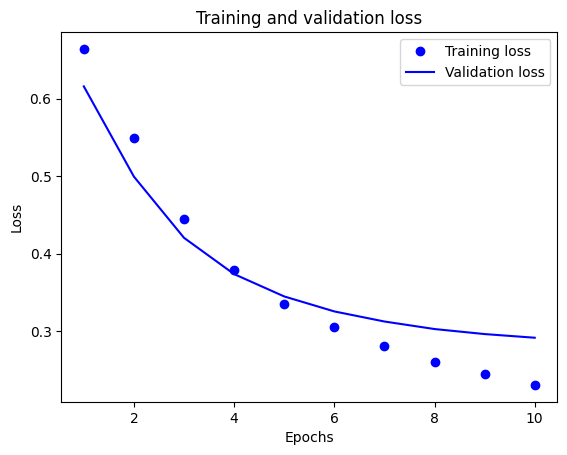

In [30]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

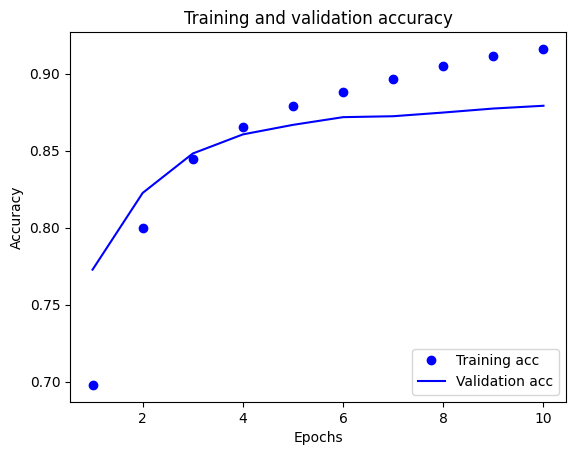

In [31]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

En este gráfico, los puntos representan la pérdida y la precisión del entrenamiento, y las líneas continuas son la pérdida y la precisión de la validación.

Observa que la pérdida de entrenamiento *disminuye* con cada época y la precisión de entrenamiento *aumenta* con cada época. Esto es lo esperado cuando se usa una optimización de descenso de gradiente - debería minimizar la cantidad deseada en cada iteración.

Este no es el caso para la pérdida de validación y la precisión-parecen alcanzar su punto máximo antes que la precisión de entrenamiento. Esto es un ejemplo de sobreajuste: el modelo funciona mejor con los datos de entrenamiento que con los datos que nunca ha visto antes. Después de este punto, el modelo se sobreoptimiza y aprende representaciones *específicas* de los datos de entrenamiento que no se *generalizan* a los datos de prueba.

En este caso concreto, se podría evitar la sobreoptimización simplemente deteniendo el entrenamiento cuando la precisión de validación deje de aumentar. Una forma de hacerlo es utilizar el callback `tf.keras.callbacks.EarlyStopping`.

## Exportar el modelo

En el código anterior, has aplicado la capa `TextVectorization` al conjunto de datos antes de introducir el texto en el modelo. Si quieres que tu modelo sea capaz de procesar cadenas de texto sin procesar (por ejemplo, para simplificar su despliegue), puedes incluir la capa `TextVectorization` dentro de tu modelo. Para ello, puede crear un nuevo modelo utilizando los pesos que acaba de entrenar.

In [32]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 5s 6ms/step - loss: 0.3101 - accuracy: 0.8739
0.8739200234413147


### Inferencia sobre nuevos datos

Para obtener predicciones de nuevos ejemplos, basta con llamar a `model.predict()`.

In [36]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
  "it was the worst movie"
  
]

export_model.predict(examples)

1/1 [==============================] - 0s 33ms/step


array([[0.6093875 ],
       [0.43252438],
       [0.2634781 ]], dtype=float32)

La inclusión de la lógica de preprocesamiento de texto en el modelo permite exportar un modelo para producción que simplifica el despliegue y reduce la posibilidad de que se produzcan desviaciones entre el entrenamiento y la prueba (https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew).

Hay que tener en cuenta una diferencia de rendimiento a la hora de elegir dónde aplicar la capa TextVectorization. Si la utilizas fuera de tu modelo, podrás realizar un procesamiento asíncrono en la CPU y almacenar los datos en el búfer cuando entrenes en la GPU. Por lo tanto, si vas a entrenar tu modelo en la GPU, es probable que quieras optar por esta opción para obtener el mejor rendimiento mientras desarrollas tu modelo, y luego cambiar a la inclusión de la capa TextVectorization dentro de tu modelo cuando estés listo para prepararte para el despliegue.

Visita este [tutorial](https://www.tensorflow.org/tutorials/keras/save_and_load) para obtener más información sobre cómo guardar modelos.